[INFO] Fragment: 6.00-12.00s -> 9601 próbek (~3.00s)


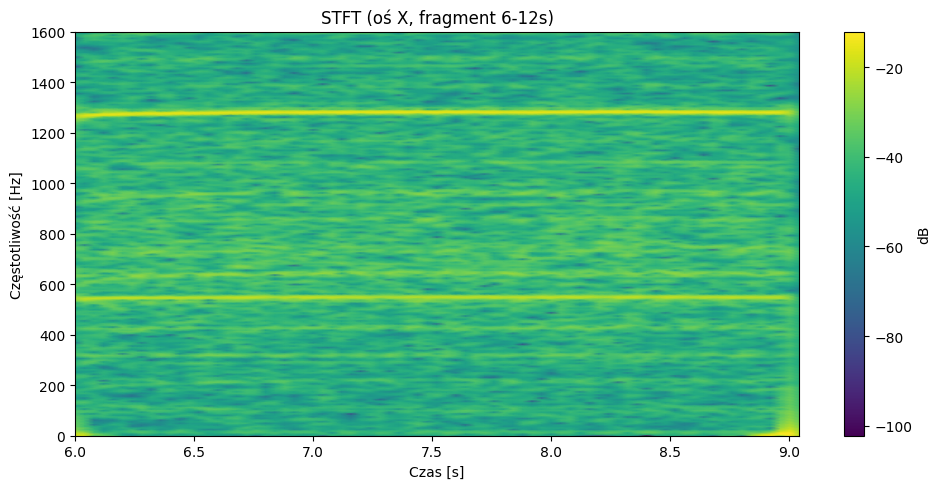

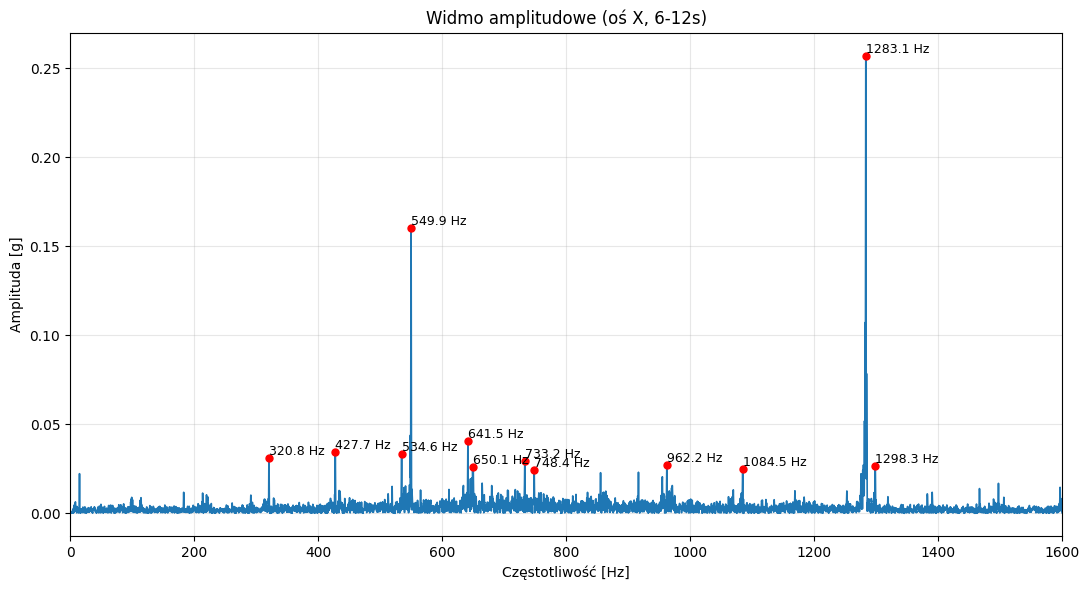


=== TOP PEAKI (częstotliwość [Hz], amplituda [g]) ===
1283.06 Hz     0.2571 g
 549.85 Hz     0.1601 g
 641.48 Hz     0.0404 g
 427.66 Hz     0.0345 g
 534.62 Hz     0.0335 g
 320.75 Hz     0.0312 g
 733.15 Hz     0.0296 g
 962.23 Hz     0.0269 g
1298.32 Hz     0.0268 g
 650.07 Hz     0.0260 g
1084.52 Hz     0.0249 g
 748.41 Hz     0.0244 g


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

fs = 3200
lsb_to_g = 0.0039
t_start, t_end = 6, 12

fmax_plot = 1600
n_fft_pad_factor = 8
peak_prominence = 0.01
peak_distance_hz = 5.0
num_top_peaks = 12

df = pd.read_csv('data/pomiary_05_11_25/05_pomiar_z_10_3200Hz.csv') 
df['X_g'] = df['X'] * lsb_to_g
t = df['czas [s]'].to_numpy()
x_raw = df['X_g'].to_numpy()

mask = (t >= t_start) & (t <= t_end)
t_seg = t[mask]; x_seg = x_raw[mask]
print(f"[INFO] Fragment: {t_start:.2f}-{t_end:.2f}s -> {len(x_seg)} próbek (~{len(x_seg)/fs:.2f}s)")

# Bias + HP
N0 = int(min(len(x_seg), 2 * fs))
x0 = x_seg - np.mean(x_seg[:N0])
b, a = signal.butter(2, 5.0/(fs/2), btype='highpass')
x_hp = signal.filtfilt(b, a, x0)

# STFT
f_stft, tt_stft, Sxx = signal.stft(x_hp, fs=fs, window='hann', nperseg=512, noverlap=384)
plt.figure(figsize=(10,5))
plt.pcolormesh(tt_stft + t_start, f_stft, 20*np.log10(np.abs(Sxx)+1e-12), shading='gouraud')
plt.ylim(0, fmax_plot); plt.xlabel('Czas [s]'); plt.ylabel('Częstotliwość [Hz]')
plt.title(f'STFT (oś X, fragment {t_start}-{t_end}s)')
plt.colorbar(label='dB'); plt.tight_layout(); plt.show()

# FFT z oknem + zero-padding
w = signal.windows.hann(len(x_hp), sym=False)
CG = np.sum(w)/len(w)
xw = x_hp * w
N = len(xw)
N_fft = int(2**np.ceil(np.log2(N))) * n_fft_pad_factor
X = np.fft.rfft(xw, n=N_fft)
freqs = np.fft.rfftfreq(N_fft, 1/fs)
amp = (2.0/(N*CG))*np.abs(X); amp[0] /= 2.0

# Detekcja peaków
def find_peaks_with_freqs(freqs, amp, fmax=None, prominence=0.01, distance_hz=5.0):
    mask = (freqs <= fmax) if fmax is not None else np.ones_like(freqs, bool)
    fc = freqs[mask]; ac = amp[mask]
    df = fc[1]-fc[0]
    peaks, props = signal.find_peaks(ac, prominence=prominence, distance=max(1,int(np.round(distance_hz/df))))
    return peaks, props, fc, ac

peaks, props, fc, ac = find_peaks_with_freqs(freqs, amp, fmax=fmax_plot,
                                             prominence=peak_prominence,
                                             distance_hz=peak_distance_hz)

order = np.argsort(ac[peaks])[::-1]
top_idx = peaks[order][:num_top_peaks]
top_freqs = fc[top_idx]
top_amps  = ac[top_idx]

# Wykres FFT
plt.figure(figsize=(11,6))
plt.plot(freqs, amp, lw=1.2)
plt.xlim(0, fmax_plot); plt.xlabel('Częstotliwość [Hz]'); plt.ylabel('Amplituda [g]')
plt.title(f'Widmo amplitudowe (oś X, {t_start}-{t_end}s)')

# piki
for f, a in zip(top_freqs, top_amps):
    plt.plot([f],[a],'ro', ms=5)
    plt.text(f, a, f'{f:.1f} Hz', fontsize=9, ha='left', va='bottom')

plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

print("\n=== TOP PEAKI (częstotliwość [Hz], amplituda [g]) ===")
for f, a in zip(top_freqs, top_amps):
    print(f"{f:7.2f} Hz   {a:8.4f} g")
